In [2]:
import numpy
import matplotlib.pyplot as plt
import texplot
from glob import glob
from pprint import pprint
from os.path import join
import freealg as fa
import time

In [3]:
# =======
# get eig
# =======

def _get_eig(filename):
    data = numpy.load(filename, allow_pickle=True)['res'].item()
    eig = data['eig']
    subsize = data['subsize']
    wall_time = data['wall_time']
    proc_time = data['proc_time']
    
    return subsize, eig, wall_time, proc_time


# ==========
# read files
# ==========

def read_files(dir_, filename):

    filenames = sorted(glob(join(dir_, filename)))
    pprint(filenames)
    print('')
    
    eigs = []
    subsizes = []
    wall_times = []
    proc_times = []
    for filename in filenames:
        subsize, eig, wall_time, proc_time = _get_eig(filename)
        subsizes.append(subsize)
        eigs.append(eig)
        wall_times.append(wall_time)
        # print(f'wall_time: {wall_time/3600:>0.2f} hr')
        print(f'subsize: {subsize:>6d}, wall_time: {wall_time:>8.2f}, proc_time: {proc_time:>8.2f}')
    
    wall_times = numpy.array(wall_times)

    return subsizes, eigs, filenames

In [4]:
# ===============
# hist of log var
# ===============

def hist(eig, nbins, clip_x=None):
    """
    Histogram of the log os a variable.
    """
    
    u = eig

    if clip_x is not None:
        u = u[numpy.logical_and(u >= clip_x[0], u <= clip_x[1])]
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = u_mid
    density = counts
    return lambda_, density


# ===============
# hist of log var
# ===============

def hist_of_log_var(eig, nbins, clip_x=None):
    """
    Histogram of the log os a variable.
    """

    if clip_x is not None:
        eig = eig[numpy.logical_and(eig >= clip_x[0], eig <= clip_x[1])]
    
    u = numpy.log10(eig[eig>0])
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = u_mid
    density = counts
    return lambda_, density


# =================
# hist in log scale
# =================

def hist_in_log_scale(eig, nbins, clip_x=None):
    """
    Histogram of a variable itself, but in log scale.
    """

    if clip_x is not None:
        eig = eig[numpy.logical_and(eig >= clip_x[0], eig <= clip_x[1])]
    
    u = numpy.log10(eig[eig>0])
    bins_u = numpy.linspace(u.min(), u.max(), nbins)
    counts, bin_edges = numpy.histogram(u, bins=bins_u, density=True)
    u_mid = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    lambda_ = 10.0**u_mid
    density = counts / lambda_
    return lambda_, density


# ============
# get all hist
# ============

def get_all_hist(subsizes, eigs, clip_x):
    
    log_xs = []
    log_rhos = []
    xs = []
    rhos = []
    print('')
    
    for subsize, eig in zip(subsizes, eigs):
        
        nbins = int(numpy.log(subsize) * 15)
        print(f'nbins: {nbins}')
        
        # x, rho = hist_in_log_scale(eig, nbins)
        # x, rho = hist(eig, nbins, clip_x=[1e-2, 1e1])
        x, rho = hist_in_log_scale(eig, nbins, clip_x=clip_x)
        xs.append(x)
        rhos.append(rho)
        
        log_x, log_rho = hist_of_log_var(eig, nbins, clip_x=clip_x)
        log_xs.append(log_x)
        log_rhos.append(log_rho)
    print('')

    return xs, rhos, log_xs, log_rhos

# Loading Data

In [5]:
dir_ = '.'
filename = './data/cifar_resnet50_fp64_logm_n55K_eig_n[0-9][0-9][0-9][0-9][0-9].npz'
clip_x = [1e-2, 1e3]

subsizes, eigs, filenames = read_files(dir_, filename)

# Scale to adjust the matrix
num_model_param = 23574015
scale = numpy.sqrt(num_model_param)
log_scale = numpy.log(scale)

for i in range(len(eigs)):
    eigs[i] = eigs[i] + log_scale

xs, rhos, log_xs, log_rhos = get_all_hist(subsizes, eigs, clip_x)

['././data/cifar_resnet50_fp64_logm_n55K_eig_n01024.npz',
 '././data/cifar_resnet50_fp64_logm_n55K_eig_n02048.npz',
 '././data/cifar_resnet50_fp64_logm_n55K_eig_n04096.npz',
 '././data/cifar_resnet50_fp64_logm_n55K_eig_n08192.npz',
 '././data/cifar_resnet50_fp64_logm_n55K_eig_n16384.npz',
 '././data/cifar_resnet50_fp64_logm_n55K_eig_n32768.npz',
 '././data/cifar_resnet50_fp64_logm_n55K_eig_n50056.npz']

subsize:   1024, wall_time:     0.50, proc_time:     6.53
subsize:   2048, wall_time:     0.32, proc_time:    10.22
subsize:   4096, wall_time:     1.82, proc_time:    50.90
subsize:   8192, wall_time:    12.50, proc_time:   358.90
subsize:  16384, wall_time:    94.30, proc_time:  2820.21
subsize:  32768, wall_time:   667.75, proc_time: 20451.25
subsize:  50056, wall_time:  2178.51, proc_time: 67331.13

nbins: 103
nbins: 114
nbins: 124
nbins: 135
nbins: 145
nbins: 155
nbins: 162



In [6]:
subsizes

[1024, 2048, 4096, 8192, 16384, 32768, 50056]

# Plotting PDF of Data

In [7]:
# ----------------------
# Estimatre pdf from eig
# ----------------------

pdfs = []
x = numpy.linspace(4, 14, 1000)
for i in range(len(subsizes)):
    eig = eigs[i]
    lam_m = numpy.min(eig)
    lam_p = numpy.max(eig)
    pdf = fa.kde(eig, x, lam_m=lam_m, lam_p=lam_p, h=0.005, kernel='beta')
    pdfs.append(numpy.copy(pdf))

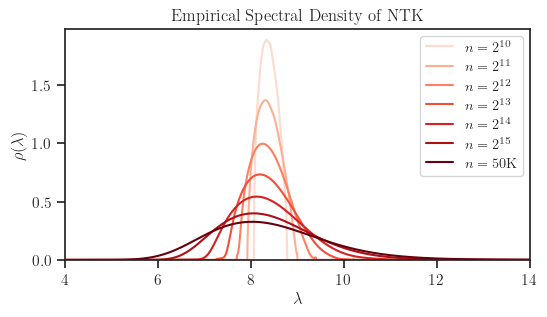

In [8]:
num_plots = len(pdfs)
cmap = plt.get_cmap('Reds')
colors = [cmap(i/(num_plots)) for i in range(num_plots + 1)][1:]

rc={'font.family': 'serif'}
with texplot.theme(rc=rc, use_latex=True):

    fig, ax = plt.subplots(figsize=(6, 3))
    
    for i in range(0, len(pdfs)):
        if i != len(pdfs) - 1:
            p = int(numpy.log2(subsizes[i]))
            label = rf'$n=2^{{{p}}}$'
        else:
            label = rf'$n={{{subsizes[i]//1000}}}$K'
        ax.plot(x, pdfs[i], color=colors[i], label=label)
        ax.set_xlim([x[0], x[-1]])
        ax.set_ylim(bottom=0)
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r'$\rho(\lambda)$')
        ax.set_title('Empirical Spectral Density of NTK')
        ax.legend(fontsize='small')

    save_filename = './plot-tmp/cifar_ntk_all_eigs.pdf'
    texplot.show_or_save_plot(plt, default_filename=save_filename,
                              transparent_background=True, dpi=200,
                              show_and_save=False, verbose=True)

# Free Decompression

In [9]:
# ------------------------------------
# Selecting One of eigs as Initial eig
# ------------------------------------

eig_init = eigs[0]
nan_mask = numpy.isnan(eig_init)
print(f'num nans: {nan_mask.sum()}')
print(f'size: {eig_init.size}')

min_eig = numpy.min(eig_init)
max_eig = numpy.max(eig_init)

print(f'min eig: {min_eig:>0.4f}')
print(f'max eig: {max_eig:>0.4f}')

num nans: 0
size: 1024
min eig: 8.0665
max eig: 8.7822


In [10]:
# ---------------
# FreeForm Object
# ---------------

eps = 0.01
ff = fa.FreeForm(eig_init, support=(min_eig - eps, max_eig + eps), delta=1e-6,
                 dtype='complex128', p=0.00001)
lam_m = ff.lam_m
lam_p = ff.lam_p

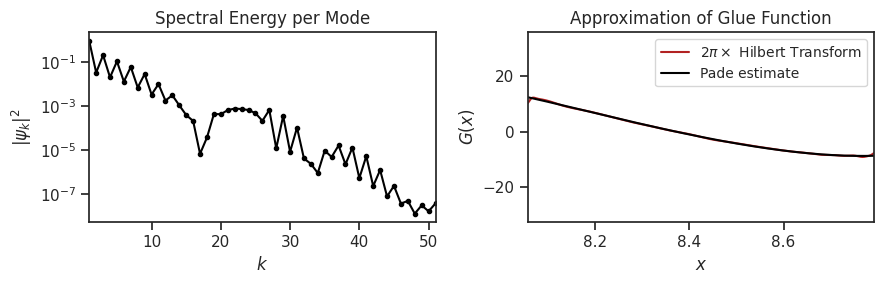

{'c': np.float64(597.4922183212783), 'D': np.float64(-76.32745052562), 'poles': array([9.63981851, 7.68827517]), 'resid': array([-56.74396169,  -2.18741949]), 'outer_iters': 41}


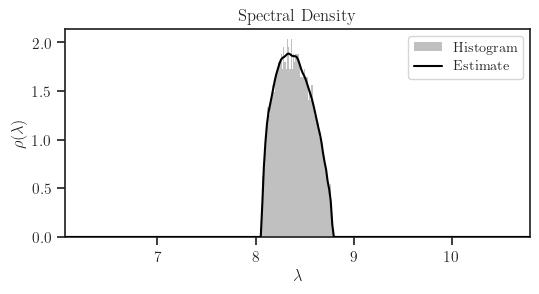

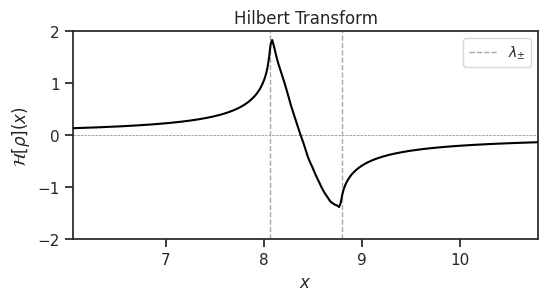

In [11]:
# ---
# Fit
# ---

psi = ff.fit(method='jacobi', K=50, alpha=2, beta=2, n_quad=60, reg=1e-2,
             projection='beta', kernel_bw=0.001, damp='jackson', force=True,
             continuation='pade', pade_p=1, pade_q=2, odd_side='left',
             pade_reg=0, optimizer='de', plot=True, save=False)
print(ff._pade_sol)

x = numpy.linspace(lam_m-2, lam_p+2, 300)
rho = ff.density(x, plot=True, latex=True, save=False)
hilb = ff.hilbert(x, rho, plot=True, save=False)

Plot saved to "/home/sia/work/scripts/free/ntk/./plot-tmp/cifar_ntk_stieltjes.pdf".


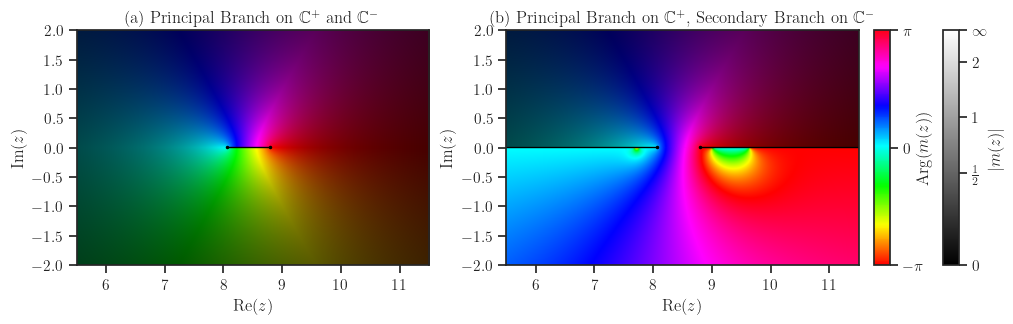

In [12]:
c = 1
# x = numpy.linspace(6, 11, 500)
x = numpy.linspace(5.5, 11.5, 500)
y = numpy.linspace(-2, 2, 500)
m1, m2 = ff.stieltjes(x, y, plot=True, latex=True, save='./plot-tmp/cifar_ntk_stieltjes.pdf')

In [13]:
# ----------
# Decompress
# ----------

x_pred = numpy.linspace(4, 14, 1000)
rhos_pred = []
eigs_pred = []
pdfs_pred = []

for subsize in subsizes:

    print(f'subsize: {subsize:>5d} | ', end='')

    init_wall_time = time.time()
    init_proc_time = time.process_time()
    
    rho_pred, _ = ff.decompress(subsize, x_pred, method='newton', max_iter=500,
                                step_size=0.1, tolerance=1e-4)

    wall_time = time.time() - init_wall_time
    proc_time = time.process_time() - init_proc_time

    print(f'wall_time: {wall_time:>5.2f}, proc_time: {proc_time:>5.2f}', end='')

    eig_pred = numpy.sort(fa.sample(x_pred, rho_pred, subsize, seed=0))
    
    rhos_pred.append(numpy.copy(rho_pred))
    eigs_pred.append(numpy.copy(eig_pred))

    # Regenerate PDF by sampling rho and apply KDE
    print(f' | regenerate PDF ... ', end='')
    lam_m = numpy.min(eig_pred)
    lam_p = numpy.max(eig_pred)
    pdf_pred = fa.kde(eig_pred, x_pred, lam_m=lam_m, lam_p=lam_p, h=0.001, kernel='beta')
    pdfs_pred.append(numpy.copy(pdf_pred))
    print('done.')

subsize:  1024 | wall_time:  0.00, proc_time:  0.00 | regenerate PDF ... done.
subsize:  2048 | wall_time:  0.67, proc_time:  0.67 | regenerate PDF ... done.
subsize:  4096 | wall_time:  0.70, proc_time:  0.70 | regenerate PDF ... done.
subsize:  8192 | wall_time:  0.77, proc_time:  0.77 | regenerate PDF ... done.
subsize: 16384 | wall_time:  1.00, proc_time:  1.00 | regenerate PDF ... done.
subsize: 32768 | wall_time:  0.89, proc_time:  0.89 | regenerate PDF ... done.
subsize: 50056 | wall_time:  1.22, proc_time:  1.22 | regenerate PDF ... done.


In [14]:
# --------------
# Regenerate PDF
# --------------

pdfs = []

for i in range(len(subsizes)):

    print(f'{i}, ', end='')

    # Original data (loaded from file)
    eig = eigs[i]
    lam_m = numpy.min(eig)
    lam_p = numpy.max(eig)
    pdf = fa.kde(eig, x_pred, lam_m=lam_m, lam_p=lam_p, h=0.001, kernel='beta')
    pdfs.append(numpy.copy(pdf))

print(' Done.')

0, 1, 2, 3, 4, 5, 6,  Done.


Plot saved to "/home/sia/work/scripts/free/ntk/./plot-tmp/cifar_ntk_all_eigs_pred-test.pdf".


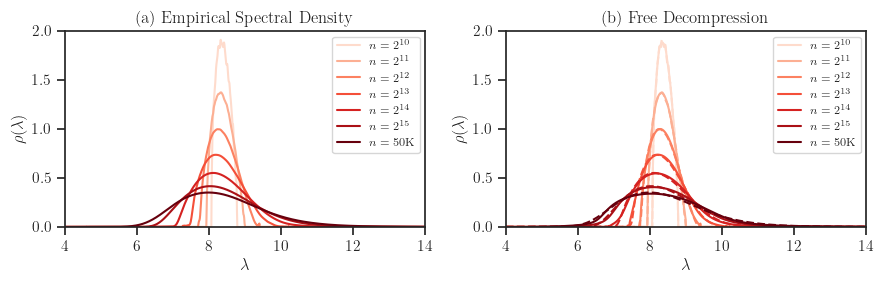

In [21]:
# ----
# Plot
# ----

num_plots = len(pdfs_pred)
cmap = plt.get_cmap('Reds')
colors = [cmap(i/(num_plots)) for i in range(num_plots + 1)][1:]

rc={'font.family': 'serif'}
with texplot.theme(rc=rc, use_latex=True):

    fig, ax = plt.subplots(figsize=(9, 3), ncols=2)
    
    for i in range(0, len(pdfs)):
        if i != len(pdfs) - 1:
            p = int(numpy.log2(subsizes[i]))
            label = rf'$n=2^{{{p}}}$'
        else:
            label = rf'$n={{{subsizes[i]//1000}}}$K'

        ax[0].plot(x_pred, pdfs[i], '-', color=colors[i], label=label)

        if i == 0:
            # ax[1].plot(x_pred, pdfs[i], '-', color=colors[i], label=label)
            ax[1].plot(x_pred, pdfs_pred[i], color=colors[i], label=label)
        else:
            ax[1].plot(x_pred, pdfs_pred[i], color=colors[i], label=label)
            # ax[1].plot(x_pred, rhos_pred[i], color=colors[i], label=label)
            
        ax[1].plot(x_pred, pdfs[i], '--', color=colors[i])

    ax[0].set_xlim([4, 14])
    # ax[0].set_ylim(bottom=0)
    ax[0].set_ylim([0, 2])
    ax[0].set_xlabel(r'$\lambda$')
    ax[0].set_ylabel(r'$\rho(\lambda)$')
    ax[0].set_title('(a) Empirical Spectral Density')
    ax[0].legend(fontsize='x-small')
        
    ax[1].set_xlim([4, 14])
    # ax[1].set_ylim(bottom=0)
    ax[1].set_ylim([0, 2])
    ax[1].set_xlabel(r'$\lambda$')
    ax[1].set_ylabel(r'$\rho(\lambda)$')
    ax[1].set_title('(b) Free Decompression')
    ax[1].legend(fontsize='x-small')
    
    plt.tight_layout()

    save_filename = './plot-tmp/cifar_ntk_all_eigs_pred-test.pdf'
    texplot.show_or_save_plot(plt, default_filename=save_filename,
                                      transparent_background=True, dpi=200,
                                      show_and_save=True, verbose=True)

In [22]:
plot_data = {
    'subsizes': subsizes,
    'eigs': eigs,
    'x_pred': x_pred,
    'pdfs': pdfs,
    'pdfs_pred': pdfs_pred,
}

numpy.save('plot_data_cifar_ntk.npy', plot_data)